<a href="https://colab.research.google.com/github/aviax1/AE1/blob/master/newindex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**dependencies**

In [ ]:
!pip install wandb

In [ ]:
import torch,wandb,os,warnings,csv
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from tensorflow.keras.datasets import mnist
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

**initial**

In [ ]:
(xtrain,ytrain), (xtest,ytest) = mnist.load_data()
num_epochs=1000        #
batch_size = 64        #
image_size=784         #
hidden_size=256         #
lv_size = 48           # Latent Variable 
learning_rate=1e-4     #
cret = nn.MSELoss()    # criterion
warnings.filterwarnings('ignore')

**build model**

In [ ]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, hidden_size), 
            nn.ReLU(True), nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True), nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True), nn.Linear(hidden_size, hidden_size),
             nn.ReLU(True), nn.Linear(hidden_size, lv_size))
        self.decoder = nn.Sequential(
            nn.Linear(lv_size, hidden_size),nn.ReLU(True),
            nn.Linear(hidden_size, hidden_size),nn.ReLU(True),
            nn.Linear(hidden_size, hidden_size),nn.ReLU(True),
            nn.Linear(hidden_size, hidden_size),nn.ReLU(True),
             nn.Linear(hidden_size, image_size), nn.Tanh())

    def forward(self, x):
        return self.decoder(self.encoder(x))

**model setting**

In [ ]:
model = autoencoder()
tmodel=autoencoder()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

class DigitDataSet(Dataset):
  def __init__(self, dataset):
      self.dataset = dataset
      self.transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])

  def __len__(self):
      return len(self.dataset)

  def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()
      return self.transform( self.dataset[idx,:,:])

**classsifcation by train models**

In [ ]:
def model_name(digit):
  return './ae_'+str(digit)+'.pth'

def get_prediction(data=xtest):
  nn=len(data)
  dataloader = DataLoader(DigitDataSet(data), batch_size=nn,shuffle=0 , num_workers=4)
  diff = np.zeros( (nn,10),dtype=np.float32 )
  for i in range(10):
    for data in dataloader:
      input_imgs = data
      imgs = Variable(input_imgs.view(input_imgs.size(0), -1))
      tmodel.load_state_dict(torch.load(model_name(i)))
      tmodel.eval()
      output_imgs = tmodel(imgs)
      for i2 in range(len( output_imgs[:,0])):
        im_pred=output_imgs.detach().numpy()[i2,:]
        im_org=imgs.numpy()[i2,:]
        difmat=np.abs(im_pred.reshape(28,28)-im_org.reshape(28,28))
        diff[i2,i]=np.sum( np.sum( difmat ))
  return np.argmin(diff, axis=1)


def testmodel(): 
  nn=len(ytest)
  min_index =get_prediction()
  seccess =  min_index == ytest
  counts, bins = np.histogram(ytest[ min_index != ytest ])
  plt.hist(bins[:-1], bins, weights=counts)
  plt.title("error by digit")
  plt.show()
  accurcy =int(10000*np.sum(seccess))/(nn*100)
  error_rate = int(10000*np.sum(min_index != ytest))/(nn*100)
  print(str(accurcy) + "% accuracy or "+str(error_rate)+"% error rate")
  return counts, bins ,len(ytest[min_index != ytest]) , len(ytest)

**train method**

In [ ]:
def save_model(digit,model):
  mn=model_name(digit)
  torch.save(model.state_dict(),mn )
  wandb.save(mn)
  print("save model "+ mn)

def load_model_ifexist(digit,model):
  mn=model_name(digit)
  if os.path.isfile(mn):
    model.load_state_dict(torch.load(mn))
    model.eval()
  return model

def train_by_digit(by_digit,model,ne=num_epochs,opt=optimizer):
  model=load_model_ifexist( by_digit,model)
  wandb.init()
  print("*****\nstart traning Model for digit " +str(by_digit) +"\n")
  dataloader = DataLoader(DigitDataSet(xtrain[ytrain==by_digit]), batch_size=batch_size,shuffle=True, num_workers=6)
  for epoch in range(ne):
    run=  epoch%25==0
    run2= epoch%125==0 and epoch >0
    for data in dataloader:
      imgs = Variable(data.view(data.size(0), -1))
      output_imgs = model(imgs)
      loss = cret(output_imgs, imgs)
      opt.zero_grad()
      loss.backward()
      opt.step()
      if run:
        run=0
        im=data[0,0,:,:].reshape(28,28)
        pred=model(imgs).detach().numpy()[0,:].reshape(28,28)
        wandb.log({"img": [wandb.Image(pred, caption="preidciton"),wandb.Image(im, caption="original")]})
      if run2:
        run2=0
        save_model(by_digit,model)
        testmodel()
        
    print('epoch [{}/{}], loss:{:.4f}' .format(epoch + 1, ne, loss.data))
    wandb.log({"loss": loss.data})
  save_model(by_digit,model)
  print("\nfinish traning Model Number " +str(by_digit) +"\n*****\n")

**train new model**

*****
start traning Model for digit 0

epoch [1/33], loss:0.2540
epoch [2/33], loss:0.2346
epoch [3/33], loss:0.2498
epoch [4/33], loss:0.2494
epoch [5/33], loss:0.2427
epoch [6/33], loss:0.1962
epoch [7/33], loss:0.1874
epoch [8/33], loss:0.1951
epoch [9/33], loss:0.1958
epoch [10/33], loss:0.1897
epoch [11/33], loss:0.1944
epoch [12/33], loss:0.1762
epoch [13/33], loss:0.1581
epoch [14/33], loss:0.1594
epoch [15/33], loss:0.1626
epoch [16/33], loss:0.1446
epoch [17/33], loss:0.1418
epoch [18/33], loss:0.1449
epoch [19/33], loss:0.1406
epoch [20/33], loss:0.1246
epoch [21/33], loss:0.1211
epoch [22/33], loss:0.1230
epoch [23/33], loss:0.1256
epoch [24/33], loss:0.1252
epoch [25/33], loss:0.1281
epoch [26/33], loss:0.1179
epoch [27/33], loss:0.1205
epoch [28/33], loss:0.1134
epoch [29/33], loss:0.1204
epoch [30/33], loss:0.1252
epoch [31/33], loss:0.1160
epoch [32/33], loss:0.1064
epoch [33/33], loss:0.1082
save model ./ae_0.pth

finish traning Model Number 0
*****



*****
start traning Model for digit 1

epoch [1/33], loss:0.0437
epoch [2/33], loss:0.0490
epoch [3/33], loss:0.0377
epoch [4/33], loss:0.0299
epoch [5/33], loss:0.0362
epoch [6/33], loss:0.0331
epoch [7/33], loss:0.0330
epoch [8/33], loss:0.0337
epoch [9/33], loss:0.0404
epoch [10/33], loss:0.0219
epoch [11/33], loss:0.0246
epoch [12/33], loss:0.0256
epoch [13/33], loss:0.0286
epoch [14/33], loss:0.0433
epoch [15/33], loss:0.0219
epoch [16/33], loss:0.0204
epoch [17/33], loss:0.0270
epoch [18/33], loss:0.0210
epoch [19/33], loss:0.0256
epoch [20/33], loss:0.0253
epoch [21/33], loss:0.0165
epoch [22/33], loss:0.0256
epoch [23/33], loss:0.0302
epoch [24/33], loss:0.0174
epoch [25/33], loss:0.0178
epoch [26/33], loss:0.0211
epoch [27/33], loss:0.0149
epoch [28/33], loss:0.0230
epoch [29/33], loss:0.0189
epoch [30/33], loss:0.0241
epoch [31/33], loss:0.0197
epoch [32/33], loss:0.0158
epoch [33/33], loss:0.0216
save model ./ae_1.pth

finish traning Model Number 1
*****



*****
start traning Model for digit 2

epoch [1/33], loss:0.1812
epoch [2/33], loss:0.1931
epoch [3/33], loss:0.1456
epoch [4/33], loss:0.1403
epoch [5/33], loss:0.1515
epoch [6/33], loss:0.1435
epoch [7/33], loss:0.1132
epoch [8/33], loss:0.1422
epoch [9/33], loss:0.1558
epoch [10/33], loss:0.1466
epoch [11/33], loss:0.1124
epoch [12/33], loss:0.1199
epoch [13/33], loss:0.1273
epoch [14/33], loss:0.1652
epoch [15/33], loss:0.1336
epoch [16/33], loss:0.1339
epoch [17/33], loss:0.1143
epoch [18/33], loss:0.1248
epoch [19/33], loss:0.0909
epoch [20/33], loss:0.1213
epoch [21/33], loss:0.0770
epoch [22/33], loss:0.1469
epoch [23/33], loss:0.1122
epoch [24/33], loss:0.0824
epoch [25/33], loss:0.0943
epoch [26/33], loss:0.0861
epoch [27/33], loss:0.1027
epoch [28/33], loss:0.1030
epoch [29/33], loss:0.1062
epoch [30/33], loss:0.0858
epoch [31/33], loss:0.1094
epoch [32/33], loss:0.1117
epoch [33/33], loss:0.1184
save model ./ae_2.pth

finish traning Model Number 2
*****



*****
start traning Model for digit 3

epoch [1/33], loss:0.1290
epoch [2/33], loss:0.1266
epoch [3/33], loss:0.1069
epoch [4/33], loss:0.1059
epoch [5/33], loss:0.1065
epoch [6/33], loss:0.1000
epoch [7/33], loss:0.1050
epoch [8/33], loss:0.1082
epoch [9/33], loss:0.0913
epoch [10/33], loss:0.1026
epoch [11/33], loss:0.0861
epoch [12/33], loss:0.0880
epoch [13/33], loss:0.0994
epoch [14/33], loss:0.0957
epoch [15/33], loss:0.0870
epoch [16/33], loss:0.0824
epoch [17/33], loss:0.0892
epoch [18/33], loss:0.0887
epoch [19/33], loss:0.0857
epoch [20/33], loss:0.0922
epoch [21/33], loss:0.0878
epoch [22/33], loss:0.0803
epoch [23/33], loss:0.0833
epoch [24/33], loss:0.0794
epoch [25/33], loss:0.0840
epoch [26/33], loss:0.0879
epoch [27/33], loss:0.0828
epoch [28/33], loss:0.0833
epoch [29/33], loss:0.0797
epoch [30/33], loss:0.0788
epoch [31/33], loss:0.0903
epoch [32/33], loss:0.0730
epoch [33/33], loss:0.0756
save model ./ae_3.pth

finish traning Model Number 3
*****



*****
start traning Model for digit 4

epoch [1/33], loss:0.1300
epoch [2/33], loss:0.1233
epoch [3/33], loss:0.1062
epoch [4/33], loss:0.0752
epoch [5/33], loss:0.0818
epoch [6/33], loss:0.0855
epoch [7/33], loss:0.0870
epoch [8/33], loss:0.0798
epoch [9/33], loss:0.0648
epoch [10/33], loss:0.0869
epoch [11/33], loss:0.0710
epoch [12/33], loss:0.0725
epoch [13/33], loss:0.0606
epoch [14/33], loss:0.0620
epoch [15/33], loss:0.0730
epoch [16/33], loss:0.0654
epoch [17/33], loss:0.0619
epoch [18/33], loss:0.0595
epoch [19/33], loss:0.0780
epoch [20/33], loss:0.0805
epoch [21/33], loss:0.0510
epoch [22/33], loss:0.0565
epoch [23/33], loss:0.0636
epoch [24/33], loss:0.0844
epoch [25/33], loss:0.0631
epoch [26/33], loss:0.0586
epoch [27/33], loss:0.0665
epoch [28/33], loss:0.0643
epoch [29/33], loss:0.0608
epoch [30/33], loss:0.0637
epoch [31/33], loss:0.0538
epoch [32/33], loss:0.0661
epoch [33/33], loss:0.0507
save model ./ae_4.pth

finish traning Model Number 4
*****



*****
start traning Model for digit 5

epoch [1/33], loss:0.1247
epoch [2/33], loss:0.1182
epoch [3/33], loss:0.1122
epoch [4/33], loss:0.1030
epoch [5/33], loss:0.0846
epoch [6/33], loss:0.0900
epoch [7/33], loss:0.0956
epoch [8/33], loss:0.0824
epoch [9/33], loss:0.0910
epoch [10/33], loss:0.0822
epoch [11/33], loss:0.0823
epoch [12/33], loss:0.0848
epoch [13/33], loss:0.0814
epoch [14/33], loss:0.0776
epoch [15/33], loss:0.0805
epoch [16/33], loss:0.0826
epoch [17/33], loss:0.0686
epoch [18/33], loss:0.0713
epoch [19/33], loss:0.0862
epoch [20/33], loss:0.0679
epoch [21/33], loss:0.0737
epoch [22/33], loss:0.0737
epoch [23/33], loss:0.0688
epoch [24/33], loss:0.0746
epoch [25/33], loss:0.0745
epoch [26/33], loss:0.0661
epoch [27/33], loss:0.0639
epoch [28/33], loss:0.0732
epoch [29/33], loss:0.0694
epoch [30/33], loss:0.0682
epoch [31/33], loss:0.0689
epoch [32/33], loss:0.0766
epoch [33/33], loss:0.0641
save model ./ae_5.pth

finish traning Model Number 5
*****



*****
start traning Model for digit 6

epoch [1/33], loss:0.0827
epoch [2/33], loss:0.0725
epoch [3/33], loss:0.0605
epoch [4/33], loss:0.0568
epoch [5/33], loss:0.0701
epoch [6/33], loss:0.0583
epoch [7/33], loss:0.0617
epoch [8/33], loss:0.0572
epoch [9/33], loss:0.0552
epoch [10/33], loss:0.0537
epoch [11/33], loss:0.0513
epoch [12/33], loss:0.0569
epoch [13/33], loss:0.0519
epoch [14/33], loss:0.0506
epoch [15/33], loss:0.0550
epoch [16/33], loss:0.0497
epoch [17/33], loss:0.0515
epoch [18/33], loss:0.0526
epoch [19/33], loss:0.0479
epoch [20/33], loss:0.0504
epoch [21/33], loss:0.0443
epoch [22/33], loss:0.0552
epoch [23/33], loss:0.0503
epoch [24/33], loss:0.0609
epoch [25/33], loss:0.0441
epoch [26/33], loss:0.0476
epoch [27/33], loss:0.0549
epoch [28/33], loss:0.0490
epoch [29/33], loss:0.0480
epoch [30/33], loss:0.0493
epoch [31/33], loss:0.0501
epoch [32/33], loss:0.0410
epoch [33/33], loss:0.0440
save model ./ae_6.pth

finish traning Model Number 6
*****



*****
start traning Model for digit 7

epoch [1/33], loss:0.0849
epoch [2/33], loss:0.0727
epoch [3/33], loss:0.0638
epoch [4/33], loss:0.0648
epoch [5/33], loss:0.0571
epoch [6/33], loss:0.0540
epoch [7/33], loss:0.0555
epoch [8/33], loss:0.0487
epoch [9/33], loss:0.0519
epoch [10/33], loss:0.0448
epoch [11/33], loss:0.0434
epoch [12/33], loss:0.0398
epoch [13/33], loss:0.0434
epoch [14/33], loss:0.0368
epoch [15/33], loss:0.0420
epoch [16/33], loss:0.0480
epoch [17/33], loss:0.0365
epoch [18/33], loss:0.0412
epoch [19/33], loss:0.0433
epoch [20/33], loss:0.0330
epoch [21/33], loss:0.0401
epoch [22/33], loss:0.0447
epoch [23/33], loss:0.0400
epoch [24/33], loss:0.0367
epoch [25/33], loss:0.0367
epoch [26/33], loss:0.0401
epoch [27/33], loss:0.0426
epoch [28/33], loss:0.0409
epoch [29/33], loss:0.0422
epoch [30/33], loss:0.0398
epoch [31/33], loss:0.0381
epoch [32/33], loss:0.0306
epoch [33/33], loss:0.0371
save model ./ae_7.pth

finish traning Model Number 7
*****



*****
start traning Model for digit 8

epoch [1/33], loss:0.1080
epoch [2/33], loss:0.1081
epoch [3/33], loss:0.0959
epoch [4/33], loss:0.1052
epoch [5/33], loss:0.0935
epoch [6/33], loss:0.0848
epoch [7/33], loss:0.0990
epoch [8/33], loss:0.0925
epoch [9/33], loss:0.0808
epoch [10/33], loss:0.0818
epoch [11/33], loss:0.0828
epoch [12/33], loss:0.0836
epoch [13/33], loss:0.0868
epoch [14/33], loss:0.0829
epoch [15/33], loss:0.0789
epoch [16/33], loss:0.0696
epoch [17/33], loss:0.0788
epoch [18/33], loss:0.0903
epoch [19/33], loss:0.0669
epoch [20/33], loss:0.0653
epoch [21/33], loss:0.0699
epoch [22/33], loss:0.0725
epoch [23/33], loss:0.0722
epoch [24/33], loss:0.0758
epoch [25/33], loss:0.0680
epoch [26/33], loss:0.0756
epoch [27/33], loss:0.0781
epoch [28/33], loss:0.0771
epoch [29/33], loss:0.0687
epoch [30/33], loss:0.0759
epoch [31/33], loss:0.0735
epoch [32/33], loss:0.0718
epoch [33/33], loss:0.0849
save model ./ae_8.pth

finish traning Model Number 8
*****



*****
start traning Model for digit 9

epoch [1/33], loss:0.0631
epoch [2/33], loss:0.0604
epoch [3/33], loss:0.0552
epoch [4/33], loss:0.0481
epoch [5/33], loss:0.0464
epoch [6/33], loss:0.0472
epoch [7/33], loss:0.0439
epoch [8/33], loss:0.0477
epoch [9/33], loss:0.0356
epoch [10/33], loss:0.0423
epoch [11/33], loss:0.0468
epoch [12/33], loss:0.0426
epoch [13/33], loss:0.0481
epoch [14/33], loss:0.0387
epoch [15/33], loss:0.0416
epoch [16/33], loss:0.0345
epoch [17/33], loss:0.0370
epoch [18/33], loss:0.0394
epoch [19/33], loss:0.0389
epoch [20/33], loss:0.0359
epoch [21/33], loss:0.0401
epoch [22/33], loss:0.0407
epoch [23/33], loss:0.0358
epoch [24/33], loss:0.0346
epoch [25/33], loss:0.0345
epoch [26/33], loss:0.0367
epoch [27/33], loss:0.0314
epoch [28/33], loss:0.0347
epoch [29/33], loss:0.0353
epoch [30/33], loss:0.0339
epoch [31/33], loss:0.0337
epoch [32/33], loss:0.0307
epoch [33/33], loss:0.0333
save model ./ae_9.pth

finish traning Model Number 9
*****



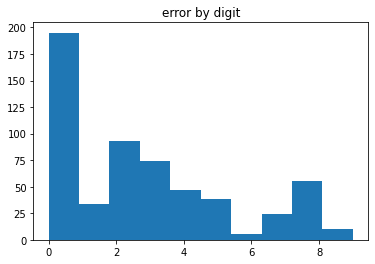

94.25% accuracy or 5.75% error rate


In [22]:
for by_digit in range(10):
  train_by_digit(by_digit,model,120)

**or used our train model**

In [ ]:
!git clone https://github.com/aviax1/AE1/
!unzip ./AE1/models.zip -d ./
!rm -rf ./AE1

**finaly test model**

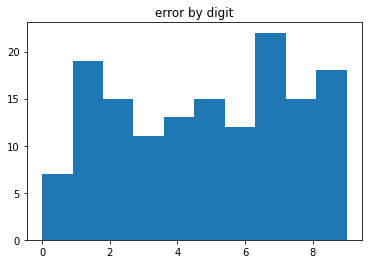

98.53% accuracy or 1.47% error rate


In [ ]:
_,_,_,_=testmodel()

**retrain the model**

In [ ]:
traget_error=0.005
error = 1
while  error > traget_error:
  counts,b,fail,total=testmodel()
  error = float(fail/total)
  if error > traget_error:
    train_by_digit(np.argmax(counts),model,30, torch.optim.Adam(model.parameters(), lr=1e-3) )

**kaggle**

In [ ]:
!git clone https://github.com/aviax1/AE1/
!unzip ./AE1/kaggle.zip -d ./
!rm -rf ./AE1

In [ ]:
inputs_test=pd.read_csv('./test.csv')
inputs_test=np.array(inputs_test,dtype=np.float32)
inputs_test=inputs_test.reshape(inputs_test.shape[0],28,28)/255
y=get_prediction(inputs_test)
imageid=1
with open('submission.csv', 'w', newline='') as csvfile:
  spamwriter = csv.writer(csvfile, delimiter=' ',    quotechar='|', quoting=csv.QUOTE_MINIMAL)
  spamwriter.writerow(['ImageId,Label'])
  for yi in y:
    spamwriter.writerow([str(imageid) +','+str( yi)])
    imageid+=1
#99.714% accuracy